# Honey Bee Health Detection
------



![](img/bees.jpg)


### [The BeeImage Dataset: Annotated Honey Bee Images](https://www.kaggle.com/jenny18/honey-bee-annotated-images)

**From the description:**
Every third bite of food relies on pollination by bees. At the same time, this past winter honeybee hive losses have exceeded 60% in some states. While many indications of hive strength and health are visible on the inside of the hive, frequent check-ups on the hive are time-consuming and disruptive to the bees' workflow and hive in general. By investigating the bees that leave the hive, we can gain a more complete understanding of the hive itself. For example, an unhealthy hive infected with varroa mites will have bees with deformed wings or mites on their backs. These characteristics can be observed without opening the hive. To protect against robber bees, we could track the ratio of pollen-carrying bees vs those without. A large influx of bees without pollen may be an indication of robber bees. This dataset aims to provide basic visual data to train machine learning models to classify bees in these categories, paving the way for more intelligent hive monitoring or beekeeping in general.

### Content
- Data Understanding and Preparation
- Run/Evaluate Custom CNN
- Run/Evaluate Inception
- Investigate Missclassified Images
- Investigate from Convolutional Layers

Author: Enrico Lauckner ([github.com/elauckne](github.com/elauckne))


Thank you to all the folks who helped providing this data set

In [1]:
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from keras import Model
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, GlobalAveragePooling2D, BatchNormalization

from src.utils import *

C:\Users\elauckner\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Variables

Minimum Size required for Inception is 139x139

In [2]:
img_height = 139
img_width = 139
img_channels = 3

## Load Data

In [3]:
bees_df = pd.read_csv('data/input/desc.csv', index_col=False)

bees_img = bees_df['file'].apply(read_transform_img, 
                                 args = (img_height, img_width, img_channels))

print(bees_df.shape)
print(bees_img[0].shape)
bees_df.head()

C:\Users\elauckner\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(5172, 9)
(139, 139, 3)


,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


## Data Understanding

### Missing Values

In [4]:
bees_df.isna().any()

file               False
date               False
time               False
location           False
zip code           False
subspecies         False
health             False
pollen_carrying    False
caste              False
dtype: bool

### Categories

In [5]:
top_categories(bees_df, 'location')

,absolute,relative
"Saratoga, CA, USA",2000,0.39
"Des Moines, IA, USA",973,0.19
"Alvin, TX, USA",737,0.14
"Athens, GA, USA",579,0.11
"Athens, Georgia, USA",472,0.09
"New Orleans, LA, USA",170,0.03
"San Jose, CA, USA",149,0.03
"Keene, NH, USA",92,0.02


In [6]:
top_categories(bees_df, 'subspecies')

,absolute,relative
Italian honey bee,3008,0.58
Russian honey bee,527,0.10
Carniolan honey bee,501,0.10
1 Mixed local stock 2,472,0.09
-1,428,0.08
VSH Italian honey bee,199,0.04
Western honey bee,37,0.01


In [7]:
top_categories(bees_df, 'health')

,absolute,relative
healthy,3384,0.65
"few varrao, hive beetles",579,0.11
"Varroa, Small Hive Beetles",472,0.09
ant problems,457,0.09
hive being robbed,251,0.05
missing queen,29,0.01


In [8]:
top_categories(bees_df, 'pollen_carrying')

,absolute,relative
False,5154,1.0
True,18,0.0


In [9]:
top_categories(bees_df, 'caste')

,absolute,relative
worker,5172,1.0


### Map

In [10]:
from geopy.geocoders import Nominatim

cities = np.array(top_categories(bees_df, 'location')['absolute'].reset_index())

# https://gis.stackexchange.com/questions/198530/plotting-us-cities-on-a-map-with-matplotlib-and-basemap

### Bee Images

Health

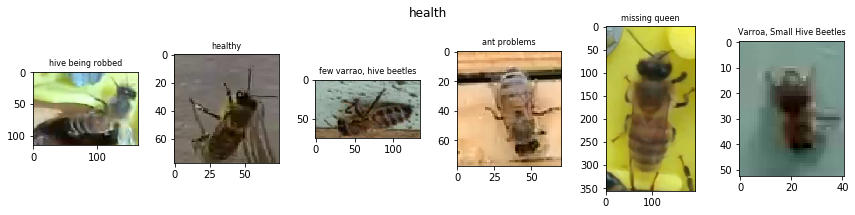

In [11]:
show_category_imgs(bees_df, 'health')

Subspecies

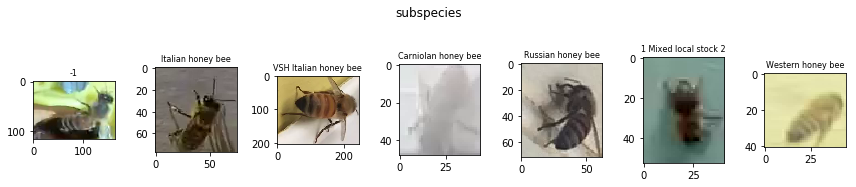

In [12]:
show_category_imgs(bees_df, 'subspecies')

## Data Preparation

Filter class 'Missing Queen' since there are only very few cases

In [13]:
mask = bees_df['health'] != 'missing queen'

bees_df = bees_df[mask]
bees_img = bees_img[mask]

Shorten / Clean up Health Categories

In [14]:
bees_df.replace({'Varroa, Small Hive Beetles': 'Varroa (SHB)'}, inplace=True)
bees_df.replace({'ant problems': 'Ants'}, inplace=True)
bees_df.replace({'few varrao, hive beetles': 'Few Varrao (HB)'}, inplace=True)
bees_df.replace({'hive being robbed': 'Hive Robbers'}, inplace=True)
bees_df.replace({'healthy': 'Healthy'}, inplace=True)

Create Model Input

In [15]:
y = pd.get_dummies(bees_df['health'])
labels = y.columns
y = y.values

x = np.stack(bees_img)

Train/Test Split 

In [16]:
trn_x, tst_x, trn_y, tst_y = train_test_split(x, y, train_size = 0.8,
                                             random_state = 666)

C:\Users\elauckner\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Image Data Generator

In [17]:
img_gen = image.ImageDataGenerator( rotation_range = 20,
                                width_shift_range = 0.2,
                                height_shift_range = 0.2,
                                horizontal_flip = True)
img_gen.fit(trn_x)

## Model

In [18]:
batch_size = 64

### Custom CNN

Create Model

In [19]:
cnn = Sequential()
cnn.add(Conv2D(6, kernel_size=3, input_shape=(img_width, img_height,img_channels), activation='relu'))
cnn.add(MaxPool2D(2))
cnn.add(Conv2D(12, kernel_size=3, activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(labels.size, activation='softmax'))
cnn.compile(optimizer='adam', loss='categorical_crossentropy', 
               metrics=['accuracy'])

Fit

In [20]:
cnn_train = cnn.fit_generator(img_gen.flow(trn_x,trn_y, batch_size=batch_size),
                  epochs=20, steps_per_epoch=batch_size,
                  validation_data=(tst_x, tst_y), verbose=0)

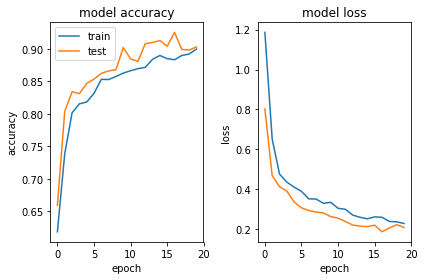

In [21]:
show_fit_performance(cnn_train)

Predict

In [22]:
tst_y_cnn = cnn.predict_proba(tst_x)

Confusion Matrix

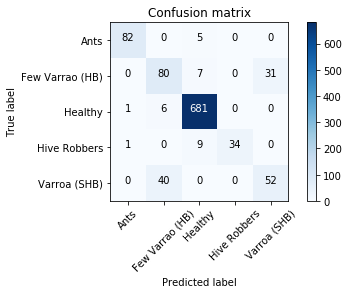

In [23]:
cm = confusion_matrix(tst_y.argmax(axis=1), tst_y_cnn.argmax(axis=1))
plot_confusion_matrix(cm, labels)

Per Class Report

In [24]:
pandas_classification_report(tst_y.argmax(axis=1), tst_y_cnn.argmax(axis=1), labels)

,support,accuracy,precision,recall,f1-score
Ants,87,0.94,0.98,0.94,0.96
Few Varrao (HB),118,0.68,0.63,0.68,0.66
Healthy,688,0.99,0.97,0.99,0.98
Hive Robbers,44,0.77,1.00,0.77,0.87
Varroa (SHB),92,0.57,0.63,0.57,0.59


In [25]:
cnn.save_weights('data/weights/cnn_1.h5')

### Inception

In [30]:
inc3_base_model = InceptionV3(weights='imagenet', include_top=False)

x = inc3_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(labels.size, activation='softmax')(x)

inc3 = Model(inputs=inc3_base_model.input, outputs=output)

for layer in inc3_base_model.layers:
    layer.trainable = False
    
inc3.compile(loss="categorical_crossentropy", optimizer="adam", 
          metrics=["accuracy"])

In [32]:
inc3.fit_generator(img_gen.flow(trn_x,trn_y, batch_size=batch_size), 
                   validation_data=(tst_x, tst_y), 
                   epochs=5, steps_per_epoch=batch_size)

Epoch 1/5
64/64 [==============================] - 857s 13s/step - loss: 0.9257 - acc: 0.6982 - val_loss: 1.0412 - val_acc: 0.7318
Epoch 2/5
64/64 [==============================] - 878s 14s/step - loss: 0.5686 - acc: 0.7871 - val_loss: 0.9155 - val_acc: 0.7551
Epoch 3/5
64/64 [==============================] - 901s 14s/step - loss: 0.4852 - acc: 0.8203 - val_loss: 1.1713 - val_acc: 0.7522
Epoch 4/5
64/64 [==============================] - 941s 15s/step - loss: 0.4501 - acc: 0.8328 - val_loss: 1.8994 - val_acc: 0.7318
Epoch 5/5
64/64 [==============================] - 1013s 16s/step - loss: 0.4312 - acc: 0.8386 - val_loss: 1.2353 - val_acc: 0.7736


Predict

In [19]:
tst_y_inc3 = inc3.predict_proba(tst_x)

Confusion Matrix

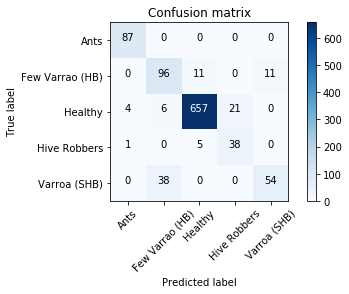

In [20]:
cm = confusion_matrix(tst_y.argmax(axis=1), tst_y_inc3.argmax(axis=1))
plot_confusion_matrix(cm, labels)

Per Class Report

In [21]:
pandas_classification_report(tst_y.argmax(axis=1), tst_y_inc3.argmax(axis=1), labels)

,support,accuracy,precision,recall,f1-score
Ants,87,1.00,0.95,1.00,0.97
Few Varrao (HB),118,0.81,0.69,0.81,0.74
Healthy,688,0.95,0.98,0.95,0.97
Hive Robbers,44,0.86,0.64,0.86,0.74
Varroa (SHB),92,0.59,0.83,0.59,0.69


### Missclassified Images

Biggest Error: Confusion between Varroa classes, especially prediction of 'Few Varrao (HB)' and true label 'Varroa (SHB)'

In [70]:
labels

Index(['Ants', 'Few Varrao (HB)', 'Healthy', 'Hive Robbers', 'Varroa (SHB)'], dtype='object')

In [85]:
idx_error = np.where((tst_y_cnn.argmax(axis=1) == 1) & (tst_y.argmax(axis=1) == 4))[0]
idx_error = random.sample(list(idx_error), 4)

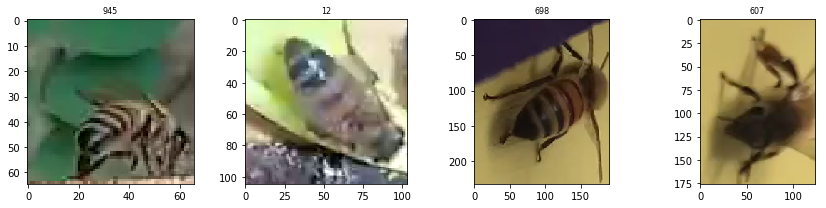

In [90]:
f, ax = plt.subplots(nrows=1,ncols=4, figsize=(12,3))
i=0

for s in idx_error:
    file='data/input/images/' + bees_df.iloc[s]['file']
    im=imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=8)
    i+=1

plt.tight_layout()
plt.show()

### Look at filters from Conv Layer

Grab random image

In [35]:
idx = random.randint(0,len(tst_x)-1)
img = tst_x[idx,:,:,:]

Visualize filters from 1st convolutional layer

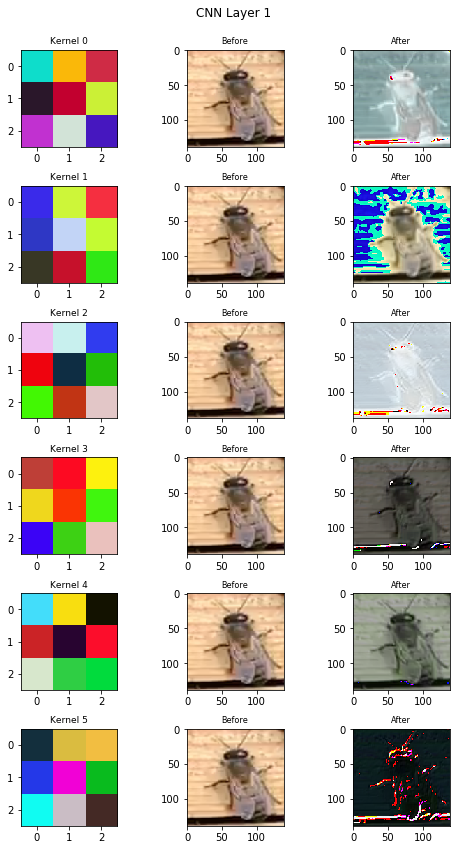

In [36]:
conv1 = cnn.layers[0]
visualize_layer_kernels(img, conv1, "CNN Layer 1")

Visualize filters from 2nd convolutional layer

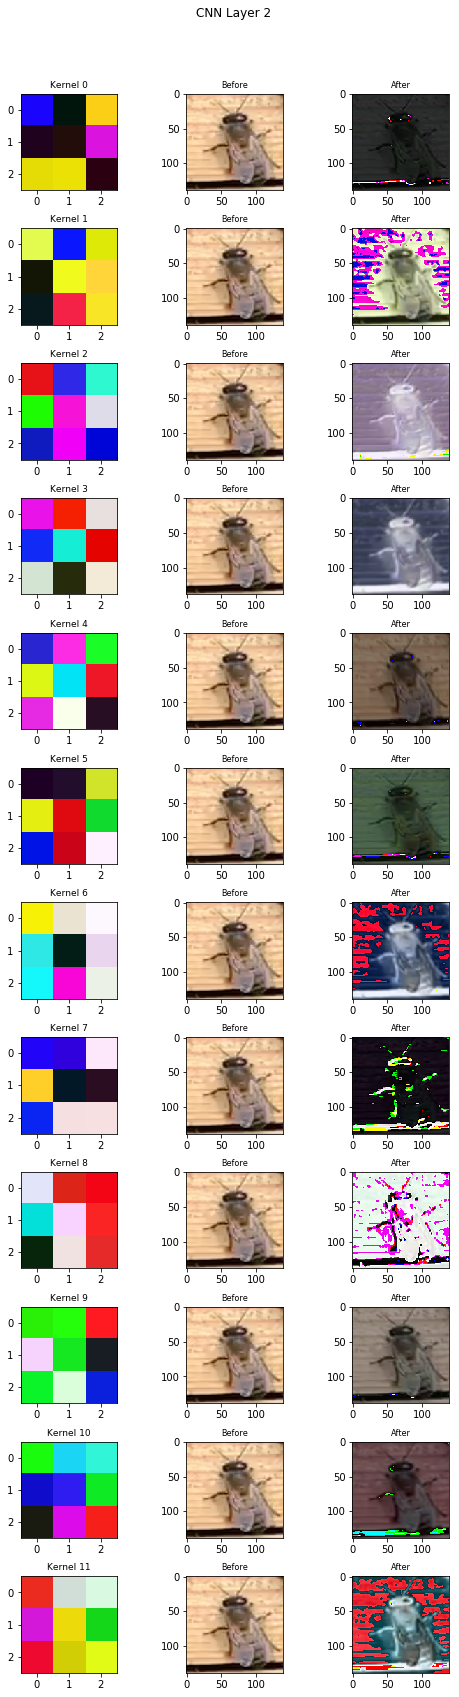

In [37]:
conv2 = cnn.layers[2]
visualize_layer_kernels(img, conv2, "CNN Layer 2")